<a href="https://colab.research.google.com/github/dhth/tour-pics-classifier/blob/master/experiments/exp_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment #1:
- Super simple classifier that predicts if an image is a **landscape shot** (can be anything -- hills, city buildings, etc.) or an image which is primarily a **close up shot of people** (sub-classification of different types of shots of people -- selfies, wide-shots etc -- to be done in further experiments.)
- Working with very less data for now -- just 240 images of each category.
- Since the task is quite simple, classifier is achieving near perfect accuracy on validation data.

### Next steps:
- Multi-label classification

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
classes = ['landscape', 'people']

In [0]:
DATA_PATH = 'local_only_data'

In [22]:
for class_name in classes:
    !wc -l {DATA_PATH}/{class_name}.txt

241 local_only_data/landscape.txt
241 local_only_data/people.txt


In [0]:
MAX_PICS = 250

In [0]:
for class_name in classes:
    
    print(class_name)
    
    folder = class_name
    file = f'{class_name}.txt'
    
    path = Path(DATA_PATH)
    dest = path/folder
    dest.mkdir(parents=True, exist_ok=True)
    
    download_images(path/file, dest, max_pics=MAX_PICS)

In [0]:
BATCH_SIZE = 32

In [0]:
path = Path(DATA_PATH)

In [60]:
!ls local_only_data/landscape/ | head

00000000.jpg
00000001.png
00000002.png
00000003.jpg
00000004.jpg
00000005.jpg
00000006.jpg
00000007.jpg
00000008.jpg
00000009.jpg


In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.3,
        ds_tfms=get_transforms(do_flip=True, max_rotate=0.2, max_warp=0.2), size=224, num_workers=8, bs=BATCH_SIZE).normalize(imagenet_stats)

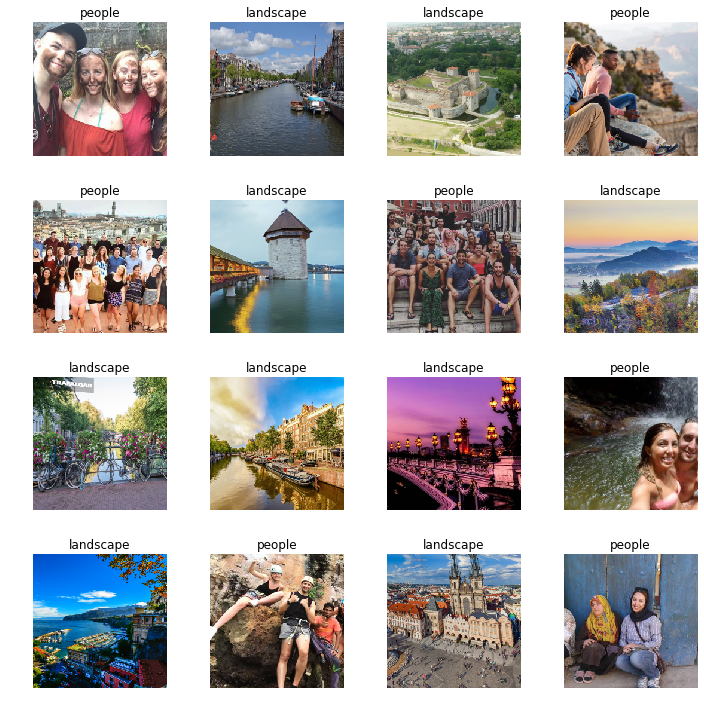

In [68]:
data.show_batch(rows=4, figsize=(10,10))

In [69]:
print(data.classes)
print(f'Training size: {len(data.train_ds)}')
print(f'Validation size: {len(data.valid_ds)}')
print(f'Total: {len(data.train_ds) + len(data.valid_ds)}')

['landscape', 'people']
Training size: 143
Validation size: 61
Total: 204


## Training: ResNet-34

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
# learn.lr_find()

In [0]:
# learn.recorder.plot()

In [0]:
lr = 1e-3

In [73]:
learn.fit_one_cycle(2, lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.680167,0.251795,0.065574,01:13
1,0.428523,0.108485,0.000000,01:12


In [0]:
learn.save('exp-2-2-classes-241-im-stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

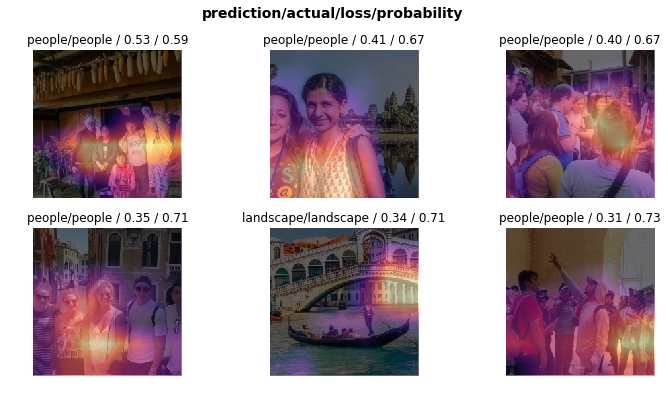

In [118]:
interp.plot_top_losses(6, figsize=(12,6), heatmap=True)

In [0]:
# interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [0]:
learn.unfreeze()

In [0]:
# learn.lr_find()

In [0]:
# learn.recorder.plot()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
DRIVE_BASE_PATH = "/content/gdrive/My\ Drive/Colab\ Notebooks/"

In [0]:
!mkdir {DRIVE_BASE_PATH}/saved_models/TR/

In [0]:
!cp local_only_data/models/2-classes-241-im-stage-1.pth {DRIVE_BASE_PATH}/saved_models/TR/

In [79]:
learn.fit_one_cycle(1, max_lr=slice(1e-5,8e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.152337,0.090006,0.000000,01:34


In [0]:
learn.save('exp-2-2-classes-241-im-stage-2')

## Testing on new data

In [0]:
!wget -q https://cdn.tourradar.com/s3/review/750x400/119336_d5e409df.jpg -O test1.jpg

In [0]:
img = open_image('test1.jpg')

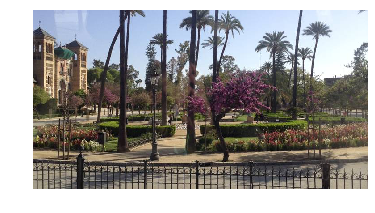

In [83]:
show_image(img,figsize=(6,4));

In [84]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category landscape

In [0]:
test_data ={
    "landscape": [
        "https://cdn.tourradar.com/s3/review/750x400/119336_436774f2.jpg",
        "https://cdn.tourradar.com/s3/review/750x400/83760_a6949507.jpg",
        "https://cdn.tourradar.com/s3/review/750x400/119336_35d71630.jpg"
        ],
                    
    "people": [
        "https://cdn.tourradar.com/s3/review/750x400/45582_825fbfb4.jpg",
        "https://cdn.tourradar.com/s3/review/750x400/45855_2cbeaf89.jpg",
        "https://cdn.tourradar.com/s3/review/750x400/45855_5dae6f94.jpg"
        ]
}

In [0]:
def fetch_test_pics(image_dict, local_dir_name, data_classes):
    !mkdir -p {local_dir_name}

    for class_name in data_classes:
        for i, el in enumerate(image_dict[class_name]):
            print(f'wget -q "{el}" -O {local_dir_name}/{class_name}_{i}.jpg')
            !wget -q "{el}" -O {local_dir_name}/{class_name}_{i}.jpg

    return Path(local_dir_name)

In [91]:
test_path = fetch_test_pics(test_data, 'local_only_test_data', data.classes)

wget -q "https://cdn.tourradar.com/s3/review/750x400/119336_436774f2.jpg" -O local_only_test_data/landscape_0.jpg
wget -q "https://cdn.tourradar.com/s3/review/750x400/83760_a6949507.jpg" -O local_only_test_data/landscape_1.jpg
wget -q "https://cdn.tourradar.com/s3/review/750x400/119336_35d71630.jpg" -O local_only_test_data/landscape_2.jpg
wget -q "https://cdn.tourradar.com/s3/review/750x400/45582_825fbfb4.jpg" -O local_only_test_data/people_0.jpg
wget -q "https://cdn.tourradar.com/s3/review/750x400/45855_2cbeaf89.jpg" -O local_only_test_data/people_1.jpg
wget -q "https://cdn.tourradar.com/s3/review/750x400/45855_5dae6f94.jpg" -O local_only_test_data/people_2.jpg


In [0]:
from math import ceil

In [0]:
def see_test_results(test_dir_path):
    test_files = test_dir_path.ls()
    
    num_cols = 3
    num_rows = ceil(len(test_files)/num_cols)
    fig,ax = plt.subplots(num_rows,num_cols)
    fig.set_size_inches(num_cols*3,num_rows*3)

    for ind, ax in enumerate(ax.flat):
        if ind>=len(test_files):
            break   
            
        x = open_image(test_files[ind])
        pred_class,pred_idx,outputs = learn.predict(x)
        xb,_ = data.one_item(x)
        xb_im = Image(data.denorm(xb)[0])
        xb_im.show(ax)
        
#         title = test_files[ind].stem.split('_')[0]
        ax.set_title(f'Predicted: {pred_class.obj}')
    
    fig.suptitle('Results', fontsize=20)

    plt.show()

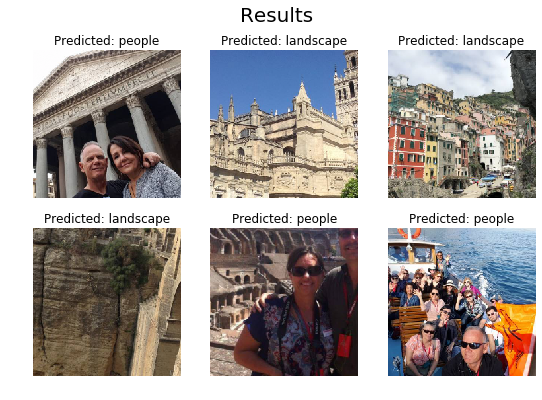

In [110]:
see_test_results(test_path)

### Tricky image

Category landscape

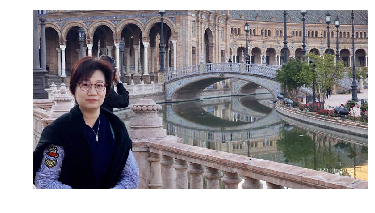

In [121]:
!wget -q https://cdn.tourradar.com/s3/review/750x400/122565_31c34726.jpg -O tricky1.jpg
tricky_img = open_image('tricky1.jpg')
show_image(tricky_img,figsize=(6,4));
pred_class,pred_idx,outputs = learn.predict(tricky_img)
pred_class

The prediction is in accordance with how the problem has been set up. The image is not a close up shot of a person, with most of its pixels covering a landscape element.